### Part I. Ising Model : a Monte Carlo Approach

$$H=J\sum_{\langle ij \rangle} S_i S_{j}$$

This is the simplest model which yields phase transitions in spin systems. 

Order parameter is the average magnetization,
$$m=\frac{1}{N}\sum_iS_i$$

Metropolis steps:

1. Prepare an initial configuration of N spins

2. Flip the spin of a randomly chosen lattice site.

3. Calculate the change in energy dE.

4. If dE < 0, accept the move. Otherwise accept the move with probability exp^{-dE/T}. This satisfies the detailed balance condition, ensuring a final equilibrium state.

5. Repeat 2-4.

In [1]:
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
from scipy.sparse import spdiags,linalg,eye

1. The spin variables can take two values $\pm 1$. We will use the following random integer generator for $N\times M$ lattice

In [2]:
2*np.random.randint(2, size=(4,4))-1

array([[ 1,  1,  1, -1],
       [-1, -1, -1,  1],
       [-1, -1, -1, -1],
       [-1,  1,  1,  1]])

Let us try to keep them as functions.

In [3]:
def wfncInit(N,M):
    return 2*np.random.randint(2, size=(N,M))-1

In [4]:
N = 4
M = 4
confi = wfncInit(N,M)

In [114]:
print(confi)
print(np.roll(confi,(0,1),axis=(0,1)))

[[-1  1 -1  1]
 [ 1 -1 -1 -1]
 [-1 -1  1 -1]
 [-1  1  1 -1]]
[[ 1 -1  1 -1]
 [-1  1 -1 -1]
 [-1 -1 -1  1]
 [-1 -1  1  1]]


2. We received the initial config. It is time to flip the randomly chosen lattice sites and calculate the energy. For this purpose we will anyway need the energy calculator.

In [5]:
def enCalcPer(config,J):
    XM1 = np.roll(config,(0, 1),axis=(0,1))
    XP1 = np.roll(config,(0,-1),axis=(0,1))
    YM1 = np.roll(config,( 1,0),axis=(0,1))
    YP1 = np.roll(config,(-1,0),axis=(0,1))
    energy = np.sum(config*(XM1+XP1+YM1+YP1))
    return energy/2.

In [6]:
J = -1
beta = 0.01
en1 = enCalcPer(confi,J)

In [7]:
en1

-4.0

3-4. Let us randomly flip one spin index and also calculate the total energy,

In [8]:
print(confi)
xr = np.random.randint(0,N)
yr = np.random.randint(0,M)

sp = confi[xr,yr]
# calculate energy cost without spin flip
enCost1 = 2*sp*(confi[(xr+1)%N,yr]+confi[(xr-1)%N,yr]+confi[xr,(yr+1)%M]+confi[xr,(yr-1)%M])*J

if enCost1 < 0:
    sp *= -1
elif rand() < np.exp(-enCost1*beta):
    sp *= -1
confi[xr,yr] = sp
print(confi)

[[-1  1  1  1]
 [-1  1 -1  1]
 [-1 -1 -1  1]
 [ 1 -1 -1 -1]]
[[-1  1  1  1]
 [-1  1 -1  1]
 [ 1 -1 -1  1]
 [ 1 -1 -1 -1]]


We now write a function that handles step 3-4.

In [9]:
def spinConfigUpd(config,J,beta):
    for i in range(N*M):
        xr = np.random.randint(0,N)
        yr = np.random.randint(0,M)

        sp = config[xr,yr]
        # calculate energy cost without spin flip
        enCost1 = 2*sp*(config[(xr+1)%N,yr]+config[(xr-1)%N,yr]+config[xr,(yr+1)%M]+config[xr,(yr-1)%M])*J

        if enCost1 < 0:
            sp *= -1
        elif rand() < np.exp(-enCost1*beta):
            sp *= -1
        config[xr,yr] = sp
    return config

We also need to calculate the average magnetization,

In [10]:
def avMag(config):
    return np.sum(config)

#### Monte Carlo Routine

We define the initial params for the simulation:

In [27]:
J       = 1          #  Ising coupling
nt      = 42         #  number of temperature points
N       = 10         #  size of the lattice, N x M
M       = 10         #  size of the lattice, N x M
eqSteps = 2**10      #  number of MC sweeps for equilibration
mcSteps = 2**10      #  number of MC sweeps for calculation


T       = np.linspace(1.1, 3.58, nt)
E,Mag,C,X = np.zeros(nt), np.zeros(nt), np.zeros(nt), np.zeros(nt)
n1, n2  = 1.0/(mcSteps*N*M), 1.0/(mcSteps*mcSteps*N*M) 

let us start the main Metropolis algorithm,

In [28]:
for tem in range(nt):
    config = wfncInit(N,M)
    
    Etem, Magtem, E2tem, Mag2tem = 0.,0.,0.,0.
    beta = 1/T[tem]; beta2 = beta**2;
    
    # equilibrate first
    for inMc in range(eqSteps):
        spinConfigUpd(config,J,beta)
    
    # do monte carlo
    for inSt in range(mcSteps):
        spinConfigUpd(config,J,beta)
        enn  = enCalcPer(config,J)
        magg = avMag(config)
        
        Etem = Etem + enn
        Magtem = Magtem + magg
        E2tem = E2tem + enn**2
        Mag2tem = Mag2tem + magg**2
    
    # calculate intensive values for thermodynamic functions
    E[tem],Mag[tem],C[tem],X[tem] = Etem*n1,Magtem*n1,(n1*E2tem - n2*Etem*Etem)*beta2,(n1*Mag2tem - n2*Magtem*Magtem)*beta

Let us plot the results,


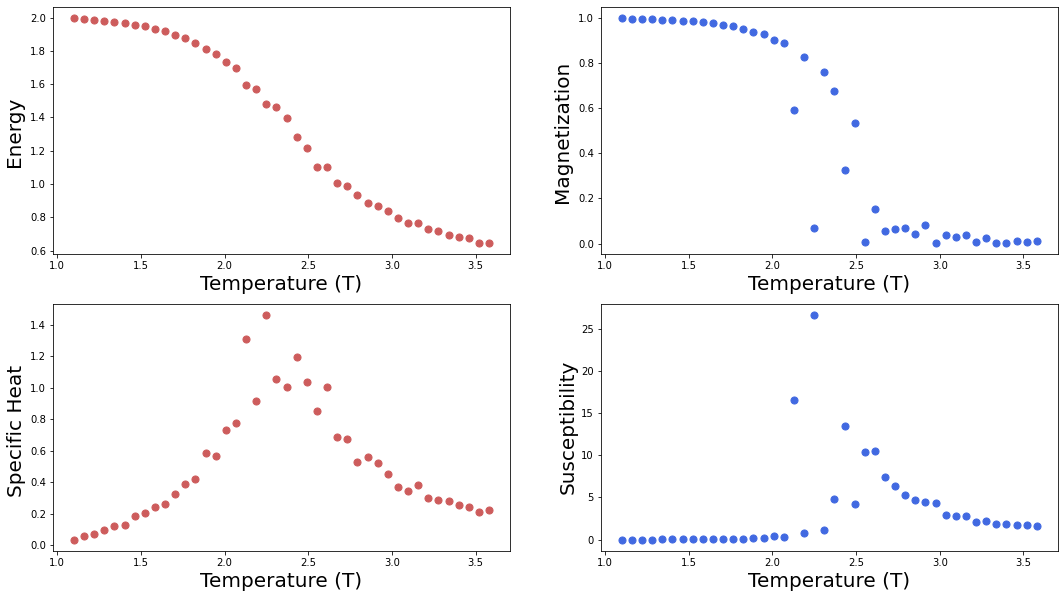

In [29]:
f = plt.figure(figsize=(18, 10)); #  

sp =  f.add_subplot(2, 2, 1 );
plt.scatter(T, E, s=50, marker='o', color='IndianRed')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Energy ", fontsize=20);        
#sp.set_xscale('log')

sp1 =  f.add_subplot(2, 2, 2 );
plt.scatter(T, abs(Mag), s=50, marker='o', color='RoyalBlue')
plt.xlabel("Temperature (T)", fontsize=20); 
plt.ylabel("Magnetization ", fontsize=20);  
#sp1.set_xscale('log')

sp2 =  f.add_subplot(2, 2, 3 );
plt.scatter(T, C, s=50, marker='o', color='IndianRed')
plt.xlabel("Temperature (T)", fontsize=20);  
plt.ylabel("Specific Heat ", fontsize=20);   
#sp2.set_xscale('log')

sp3 =  f.add_subplot(2, 2, 4 );
plt.scatter(T, X, s=50, marker='o', color='RoyalBlue')
plt.xlabel("Temperature (T)", fontsize=20); 
plt.ylabel("Susceptibility", fontsize=20);   
#sp3.set_xscale('log')

##### Discussion: Transverse Ising Model

What happens under a transverse magnetic field?
$$H_{TF}=J\sum_{\langle ij \rangle} S^z_i S^z_{j} + \sum_i h_i S^x_i.$$

Answer: It is called the Transerve Field Ising-Model. The crucial part is that 
- the degrees of freedom are constant of motion or classical anymore! 
- the quantum model of dimension $d$ can be mapped into the $d+1$ dimensional Ising model.

The approach is then to decompose the partition function into Ising and the transverse spin flip parts by a Suzuki-Trotter expansion up to 1st order. Then, using sufficient set of identity operators as the resolution of identity, one can rewrite the spin-flip operators in terms of Ising coupling and transforming the $d$ dimensional dynamic problem into a $d+1$ dimensional static problem. The following discussion is borrowed from the literature to save time,

\begin{eqnarray}
Z &=& Tr \left[ e^{-\beta H_{TF}} \right] = Tr \left[ exp\left(-\frac{\beta}{N_s} J\sum_{\langle ij \rangle} S^z_i S^z_{j} - \sum_i h_i S^x_i \right)^{N_s}\right],\\
&=& \lim_{N_s\to \infty} Tr \left[ exp\left(-\frac{\beta}{N_s} J\sum_{\langle ij \rangle} S^z_i S^z_{j}\right)^{N_s} exp\left(- \frac{\beta}{N_s}\sum_i h_i S^x_i \right)^{N_s} + \mathcal{O}(1/N^2_s)\right],\\
\end{eqnarray}

The first term is the usual Ising interaction. The second term can be expanded using a similar trick to Path Integral representation and one can insert series of identity operators,
\begin{eqnarray}
A_{i_1,i_2} &=& \langle i_1 \mid exp\left(a S^x_i \right) \mid i_2 \rangle \approx \langle i_1 \mid cosh(a) + sinh(a) S^x_i  \mid i_2 \rangle,\\
&=& \delta_{i_1,i_2}  cosh(a) + \left( \delta_{i_1,i} \delta^i_{\bar{i}_1,i_2} +  \delta_{i_2,i} \delta^i_{i_1,\bar{i}_2}\right) sinh(a)
\end{eqnarray}

Note that the $2nd$ Kronecker Delta function has barred configuration where $i^{th}$ index is flipped.

Yet, we will use another observation and rewrite it as the Ising interaction on the y-direction as follows,
\begin{eqnarray}
A_{i_1,i_2} &=& \langle i_1 \mid cosh(a) + sinh(a) S^x_i  \mid i_2 \rangle,\\
&=& \frac{1}{2} \left( e^{-a} \langle i_1 \mid S^z_{ij}S^z_{ij+1}  \mid i_2 \rangle + e^{a} \right).
\end{eqnarray}

To keep the exponential trace simple, we map it back to another exponential,
$$A_{i_1,i_2} = \Lambda e^{\gamma S^z_{i,j}S^z_{i,j+1}}$$
$$\Lambda = \sqrt{\sinh(a) \cosh(a)}, \gamma = -\frac{1}{2} \log \tanh(a)$$

This expression now can be inserted back into the Trotter expanded partition function and sampled.

##### Discussion:

What happens if we have a spin direction, a vector for each classical spin?
- Answer: It is called the classical Heisenberg model. It requires a bit more careful analysis that we will carry out here.